# Variation AutoEncoder (VAE)

latent space가 연속적인 확률 분포

In [1]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomRotation, RandomErasing
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, ConvTranspose2d, Tanh, L1Loss, CrossEntropyLoss, BatchNorm2d, Dropout
from torch.optim import Adam, lr_scheduler

import os
from time import time
from math import floor
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [3]:
# RandomErasing(p=0.2, scale=(0.02, 0.4))
# p=0.2 : 20%로 random erasing 적용
# scale=(0.02, 0.4) : 지워질 영역의 크기 비율 (2% ~ 40% 사이)
transform_train = Compose([
    RandomHorizontalFlip(),
    RandomCrop(32, padding=4),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    RandomRotation(15),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    RandomErasing(p=0.1, scale=(0.02, 0.4))
])

train = DataLoader(CIFAR10(root="data_cifar10", train=True, download=True, transform=transform_train),
                      batch_size=128,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [4]:
transform_test = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test = DataLoader(CIFAR10(root="data_cifar10", train=False, download=True, transform=transform_test),
                      batch_size=128,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [5]:
class ConvolutionalVAE(Module):
    def __init__(self):
        super().__init__()

        latent_space = 512

        # pooling layer는 기계적으로 특징을 압축시키기때문에 소실되는 정보가 많음
        # convolution layer만 사용하여 정보 소실을 막으면서 downsamnpling
        self.encoder = Sequential(
            Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(32),
            ReLU(),

            Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(64),
            ReLU(),

            Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(128),
            ReLU(),
            
            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(512),
            ReLU(),
        )

        # fully connected layer에서 laten_sapce 의 mean vector로 변환
        self.fc_mean = Linear(2 * 2 * 512, latent_space)
        # fully connected layer에서 laten_sapce 의 log variance vector로 변환
        self.fc_log_var = Linear(2 * 2 * 512, latent_space)

        self.decoder_linear = Sequential(
            # latent layer에 입력되던 image shape으로 변경
            Linear(latent_space, 2 * 2 * 512),
            ReLU()
        )
        
        self.decoder = Sequential(
            # upsampling : imnage size를 2배로 키우며 복원
            ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            ReLU(),

            ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            ReLU(),

            ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            ReLU(),
            
            # finer upsampling : 여러 단계에 걸쳐 image size는 변화하지 않고 정교하게 복원
            ConvTranspose2d(64, 32, kernel_size=2, stride=2), # 16->32
            ReLU(),
            
            ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            ReLU(),

            ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            ReLU(),
            
            # 최종 channel 3으로 줄이기
            ConvTranspose2d(16, 3, kernel_size=1, stride=1),
            Tanh()
        )

        self.classifier = Sequential(
            Linear(latent_space, 512),
            ReLU(),
            Dropout(0.1),

            Linear(512, 256),
            ReLU(),
            Dropout(0.1),
            
            Linear(256, 128),
            ReLU(),
            Dropout(0.1),
            
            Linear(128, 10)
        )

    # Reparameterization Trick
    def reparameterize(self, mean, log_var):
        # 로그 분산(log_var) -> 분산(std)
        std = torch.exp(0.5 * log_var) 

        # noise sampling (표준 정규 분포에서 샘플링한 값)
        epsilon = torch.randn_like(std)
        
        # z = mean + std * epsilon
        return mean + std * epsilon

    def forward(self, x):
        # feature map flatten
        feature_map = self.encoder(x).view(x.size(0), -1)

        mean = self.fc_mean(feature_map)
        log_var = self.fc_log_var(feature_map)

        # z
        latent_vector = self.reparameterize(mean, log_var)

        # classification
        logits = self.classifier(latent_vector)

        # reconstruction
        decoder_input = self.decoder_linear(latent_vector)
        reconstructed_img = self.decoder(decoder_input.view(-1, 512, 2, 2))

        return reconstructed_img, logits, mean, log_var

In [6]:
model = ConvolutionalVAE().to(device)

In [7]:
classification_loss_function = CrossEntropyLoss()

# batch 평균을 사용 (reduction='mean') -> batch 크기에 상관없이 안정적인 손실 계산 가능
# MSELoss = L2 loss
# MAE = L1 loss (절대값으로 계산하기 때문에 오차가 큰 이상치에 대해 덜 민감함)
# overfitting을 방지하는 L1 / L2 규제와 헷갈리지 말 것!
reconstruction_loss_function = L1Loss(reduction="mean")

learning_rate = 0.001

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [8]:
# KLD (Kullback-Leibler Divergence) : KL 발산. 두 확률 분포 간의 차이 또는 거리 측정
def kld_loss_function(mean, log_var):
    # KLD = -0.5 * mean(1 + log(sigma^2) - mean^2 - sigma^2)
    # log_var == log(sigma^2)
    # torch.exp(log_var) == sigma^2
    return -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())


In [9]:
epochs = 50

classification_weights = 0.2
vae_weights  = 0.8

total_time = list()

for epoch in range(epochs):
    now = time()
    avg_total_loss = 0.0
    avg_kld_loss = 0.0
    avg_reconstruction_loss = 0.0
    avg_classification_loss = 0.0

    for i, data in enumerate(train):
        x_train, y_train = data
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()

        reconstructed_img, logits, mean, log_var = model(x_train)

        # loss 계산
        reconstruction_loss = reconstruction_loss_function(reconstructed_img, x_train)
        kld_loss = kld_loss_function(mean, log_var)
        classification_loss = classification_loss_function(logits, y_train)

        # kl 가중치 를 30 epoch까지, 0.5까지, 점진적으로 올라가도록
        kl_weight = min(0.1, epoch / 30 * 0.5)
        # kld_loss는 sum 형태이므로 batch size로 나누어준다.
        vae_loss = reconstruction_loss + kl_weight * (kld_loss / x_train.size(0))

        # total loss = classification loss + vae loss
        # vae loss  : batch_size (x_train.size(0))로 나누어 평균 (batch 내 평균 손실을 구하기 위해)
        # -> vae loss가 reconstruction loss 와 kld loss를 reduction="sum" 하고 있기 때문에
        total_loss = (classification_weights * classification_loss) + (vae_weights * vae_loss )

        total_loss.backward()

        optimizer.step()

        avg_total_loss += total_loss.item()
        avg_kld_loss += kld_loss.item() / x_train.size(0)
        avg_reconstruction_loss += reconstruction_loss.item() / x_train.size(0)
        avg_classification_loss += classification_loss.item()
    
    scheduler.step()

    learning_time = int(time() - now)
    total_time.append(learning_time)

    len_train = len(train)

    print(f"epoch: {epoch+1:3d}/{epochs} \t {learning_time}s")
    print(f" \t - total_loss: {avg_total_loss/len_train:.3f} \t classification loss : {avg_classification_loss/len_train:.3f} \t reconstruction loss : {avg_reconstruction_loss/len_train:.3f} \t kld loss : {avg_kld_loss/len_train:.3f}")

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

epoch:   1/50 	 27s
 	 - total_loss: 0.625 	 classification loss : 1.812 	 reconstruction loss : 0.003 	 kld loss : 0.032
epoch:   2/50 	 2s
 	 - total_loss: 0.492 	 classification loss : 1.532 	 reconstruction loss : 0.002 	 kld loss : 0.021
epoch:   3/50 	 2s
 	 - total_loss: 0.453 	 classification loss : 1.402 	 reconstruction loss : 0.002 	 kld loss : 0.017
epoch:   4/50 	 3s
 	 - total_loss: 0.428 	 classification loss : 1.318 	 reconstruction loss : 0.002 	 kld loss : 0.015
epoch:   5/50 	 2s
 	 - total_loss: 0.411 	 classification loss : 1.252 	 reconstruction loss : 0.002 	 kld loss : 0.014
epoch:   6/50 	 2s
 	 - total_loss: 0.398 	 classification loss : 1.207 	 reconstruction loss : 0.002 	 kld loss : 0.013
epoch:   7/50 	 2s
 	 - total_loss: 0.387 	 classification loss : 1.163 	 reconstruction loss : 0.001 	 kld loss : 0.012
epoch:   8/50 	 2s
 	 - total_loss: 0.375 	 classification loss : 1.120 	 reconstruction loss : 0.001 	 kld loss : 0.011
epoch:   9/50 	 2s
 	 - total_l

In [10]:
test_iter = iter(test)
x_test, y_test = next(test_iter)

x_test = x_test.to(device)
y_test = y_test.to(device)

['car', 'truck', 'car', 'deer', 'car', 'plane', 'plane', 'dog', 'horse', 'horse', 'truck', 'ship', 'truck', 'cat', 'plane', 'truck', 'truck', 'deer', 'frog', 'deer', 'car', 'car', 'plane', 'car', 'frog', 'plane', 'bird', 'truck', 'truck', 'cat', 'frog', 'ship', 'car', 'deer', 'bird', 'deer', 'deer', 'deer', 'dog', 'horse', 'cat', 'cat', 'dog', 'frog', 'ship', 'plane', 'frog', 'ship', 'ship', 'plane', 'deer', 'horse', 'deer', 'ship', 'dog', 'deer', 'truck', 'frog', 'bird', 'ship', 'frog', 'frog', 'frog', 'dog', 'ship', 'truck', 'truck', 'cat', 'deer', 'dog', 'bird', 'deer', 'deer', 'plane', 'frog', 'ship', 'truck', 'cat', 'truck', 'horse', 'dog', 'bird', 'frog', 'horse', 'frog', 'dog', 'horse', 'plane', 'ship', 'dog', 'truck', 'plane', 'deer', 'horse', 'truck', 'horse', 'cat', 'car', 'ship', 'truck', 'horse', 'cat', 'bird', 'horse', 'horse', 'truck', 'plane', 'deer', 'plane', 'plane', 'car', 'horse', 'ship', 'ship', 'truck', 'car', 'horse', 'truck', 'car', 'bird', 'frog', 'plane', 'hors

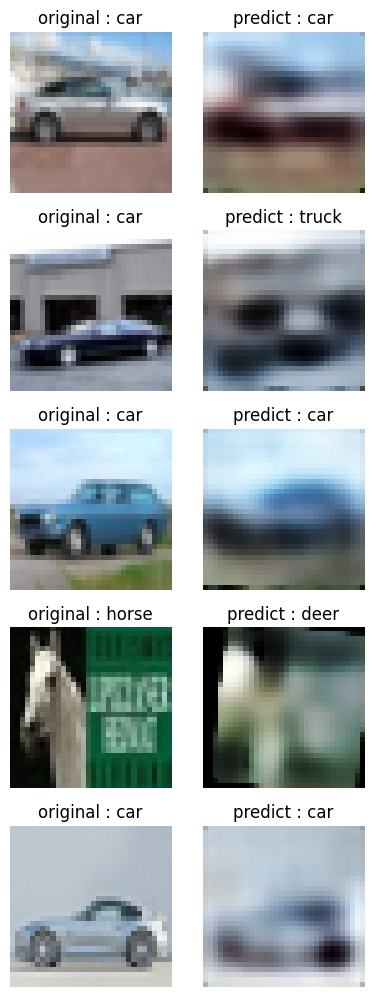

In [11]:
name_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()
with torch.no_grad():
    # reconstructed_img, logits, mean, log_var = model()
    reconstructed_img, predict, _, _ = model(x_test)
    _, predict_labels = torch.max(predict, 1)

print(list(map(lambda x: name_list[x], predict_labels.cpu().tolist())))
print(list(map(lambda x: name_list[x], y_test.tolist())))

plt.figure(figsize=(4, 20))

for i in range(5):
    plt.subplot(10, 2, 2 * i + 1)
    original = ((x_test[i].cpu().detach() * 0.5) + 0.5).permute(1, 2, 0).numpy()
    plt.imshow(original)
    plt.title("original : " + list(map(lambda x: name_list[x], y_test.cpu().tolist()))[i])
    plt.axis('off')

    plt.subplot(10, 2, 2 * i + 2)
    reconstructed = reconstructed_img[i].cpu().detach().permute(1, 2, 0).numpy()
    # minmax 
    reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min() + 1e-8)
    plt.imshow(reconstructed)
    plt.title("predict : " + list(map(lambda x: name_list[x], predict_labels.cpu().tolist()))[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
correct = 0
total = 0

for data in test:
    x_test, y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    _, h, _, _ = model(x_test)
    _, predicted = torch.max(h.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

print(f'acc : {100 * correct / total:.2f}%')

acc : 81.86%
